## Introduction to Hidden Markov Modelas with Python Networkx and Sklearn

### What is a Markov Model
A Markov chain (model) describes a stochastic process where the assumed probability of future state(s) depends only on the current process state and not on any the states that preceded it (shocker). 

Let's get into a simple example. Assume you want to model the future probability that your dog is in one of three states given its current state. To do this we need to specify the state space, the initial probabilities, and the transition probabilities. 

Imagine you have a very lazy fat dog, so we define the state space as sleeping, eating, or pooping. We will set the initial probabilities to 35%, 35%, and 30% respectively.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# create state space and initial state probabilities

states = ['sleeping', 'eating', 'pooping']
pi = [0.35, 0.35, 0.3]
state_space = pd.Series(pi, index=states, name = 'states')
print(state_space)
print(state_space.sum())

sleeping    0.35
eating      0.35
pooping     0.30
Name: states, dtype: float64
1.0


The next step is to define the transition probabilities. They are simply the probabilities of staying in the same state or moving to a different state given the current state.

q_df = pd.DataFrame(columns=states, index= states)
q_df.loc[states[0]] = [0.4, 0.2, 0.4]
q_df.loc[states[1]] = [0.45, 0.45, 0.1]
q_df.loc[states[2]] = [0.45, 0.25, 0.3]

print(q_df)

q = q_df.values
print('\n', q, q.shape, '\n')
print(q_df.sum(axis=1))

In [4]:
from pprint import pprint

# create a function that maps transition probability dataframe to markov edges and weights

def _get_markov_edges(Q):
    edges = {};
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx, col)] = Q.loc[idx, col]
    return edges

edges_wts = _get_markov_edges(q_df)
pprint(edges_wts)

{('eating', 'eating'): 0.45,
 ('eating', 'pooping'): 0.1,
 ('eating', 'sleeping'): 0.45,
 ('pooping', 'eating'): 0.25,
 ('pooping', 'pooping'): 0.3,
 ('pooping', 'sleeping'): 0.45,
 ('sleeping', 'eating'): 0.2,
 ('sleeping', 'pooping'): 0.4,
 ('sleeping', 'sleeping'): 0.4}


Now we can create the graph. To visualize a Markov model we need to use nx.MultiDiGraph(). A multidigraph is simply a directed graph which can have multiple arcs such that a single node can be both the origin and destination.

In the following code, we create the graph object, add our nodes, edges, and labels, then draw a bad networkx plot while outputting our graph to a dot file.

Nodes:
['sleeping', 'eating', 'pooping']

Edges:
[('sleeping', 'sleeping', {'lavel': 0.4, 'weight': 0.4}),
 ('sleeping', 'eating', {'lavel': 0.2, 'weight': 0.2}),
 ('sleeping', 'pooping', {'lavel': 0.4, 'weight': 0.4}),
 ('eating', 'sleeping', {'lavel': 0.45, 'weight': 0.45}),
 ('eating', 'eating', {'lavel': 0.45, 'weight': 0.45}),
 ('eating', 'pooping', {'lavel': 0.1, 'weight': 0.1}),
 ('pooping', 'sleeping', {'lavel': 0.45, 'weight': 0.45}),
 ('pooping', 'eating', {'lavel': 0.25, 'weight': 0.25}),
 ('pooping', 'pooping', {'lavel': 0.3, 'weight': 0.3})]


KeyError: 'label'

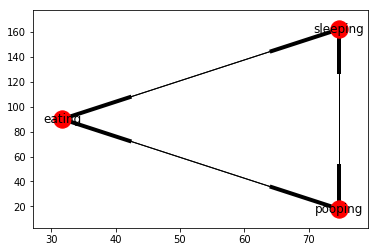

In [20]:
G = nx.MultiDiGraph()
G.add_nodes_from(states)
print(f'Nodes:\n{G.nodes()}\n')

for k,v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight = v, lavel = v)
print(f'Edges:')
pprint(G.edges(data=True))

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)

edge_labels = {(n1,n2):d['label'] for n1, n2, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G,'pet_dog_markov.dot')

### What Makes a Markov Model Hidden?
Consider a situation where your dog is acting strangely and you wanted to model the probability that your dog's behavior is due to sickness or simply quirky behavior when otherwise healthy. 

In this situation the true state of the dog is unknown, thus hidden from you. One way to model this is to assume that the dog has observable behaviors that represent the true, hidden state. Let's walk through an example. 

First we create our state space - healthy or sick. We assume they are equiprobable.

In [13]:
hidden_states = ['health', 'sick']
pi = [0.5, 0.5]
state_space = pd.Series(pi, index=hidden_states, name='states')
print(state_space)
print('\n', state_space.sum())

health    0.5
sick      0.5
Name: states, dtype: float64

 1.0


In [14]:
a_df = pd.DataFrame(columns=hidden_states, index=hidden_states)
a_df.loc[hidden_states[0]] = [0.7, 0.3]
a_df.loc[hidden_states[1]] = [0.4, 0.6]

print(a_df)

a = a_df.values
print('\n', a, a.shape, '\n')
print(a_df.sum(axis=1))

       health sick
health    0.7  0.3
sick      0.4  0.6

 [[0.7 0.3]
 [0.4 0.6]] (2, 2) 

health    1.0
sick      1.0
dtype: float64


In [16]:
observable_states = states
b_df = pd.DataFrame(columns=observable_states, index=hidden_states)
b_df.loc[hidden_states[0]] = [0.2, 0.6, 0.2]
b_df.loc[hidden_states[1]] = [0.4, 0.1, 0.5]

print(b_df)
b=b_df.values
print('\n', b, b.shape, '\n')
print(b_df.sum(axis=1))

       sleeping eating pooping
health      0.2    0.6     0.2
sick        0.4    0.1     0.5

 [[0.2 0.6 0.2]
 [0.4 0.1 0.5]] (2, 3) 

health    1.0
sick      1.0
dtype: float64


In [18]:
hide_edges_wts = _get_markov_edges(a_df)
pprint(hide_edges_wts)

emit_edges_wts = _get_markov_edges(b_df)
pprint(emit_edges_wts)

{('health', 'health'): 0.7,
 ('health', 'sick'): 0.3,
 ('sick', 'health'): 0.4,
 ('sick', 'sick'): 0.6}
{('health', 'eating'): 0.6,
 ('health', 'pooping'): 0.2,
 ('health', 'sleeping'): 0.2,
 ('sick', 'eating'): 0.1,
 ('sick', 'pooping'): 0.5,
 ('sick', 'sleeping'): 0.4}
